In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from droughts_modelling.data import DataFunctions
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers
from sklearn.preprocessing import RobustScaler
import os
import pandas as pd

'/home/jackhooper/code/realGhostFoxx/droughts_modelling'

1. Sort out the pipeline and Keras wrapper so as to package everything up to run for train/val/test data and iterate
2. Hook the trainings up to GCP and iterate over to get the best model
3. Push everything to github

In [2]:
data_class = DataFunctions()

In [3]:
train_data = data_class.light_weekly_aggregate_train()
val_data = data_class.light_weekly_aggregate_validate()
test_data = data_class.light_weekly_aggregate_test()

In [4]:
test_data

,fips_,year_,week_num_,PRECTOT_mean,PS_mean,QV2M_mean,T2M_mean,T2MDEW_mean,T2MWET_mean,T2M_MAX_mean,...,TS_mean,WS10M_mean,WS10M_MAX_mean,WS10M_MIN_mean,WS10M_RANGE_mean,WS50M_mean,WS50M_MAX_mean,WS50M_MIN_mean,WS50M_RANGE_mean,score_max
0,1001,2019,2,1.604286,100.710000,5.791429,7.820000,5.324286,5.141429,13.990000,...,7.744286,2.435714,3.325714,1.715714,1.610000,4.891429,6.487143,3.340000,3.147143,0.0
1,1001,2019,3,4.114286,100.555714,5.581429,6.798571,4.468571,4.340000,11.945714,...,6.407143,2.378571,3.431429,1.347143,2.087143,4.317143,6.152857,2.728571,3.425714,0.0
2,1001,2019,4,7.530000,100.705714,4.538571,4.972857,1.648571,1.458571,11.154286,...,4.422857,2.618571,3.755714,1.561429,2.192857,4.744286,7.060000,2.927143,4.135714,0.0
3,1001,2019,5,0.878571,100.631429,5.165714,6.250000,3.421429,3.234286,13.391429,...,6.021429,1.984286,2.894286,0.992857,1.898571,3.995714,6.041429,1.671429,4.368571,0.0
4,1001,2019,6,0.574286,100.781429,8.638571,13.088571,10.671429,10.484286,18.827143,...,13.062857,2.570000,3.352857,1.805714,1.545714,5.032857,6.378571,3.410000,2.965714,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326334,56043,2020,49,0.198571,83.754286,1.977143,-2.270000,-11.144286,-6.707143,3.998571,...,-4.080000,2.752857,3.825714,1.730000,2.098571,4.190000,5.825714,2.747143,3.077143,4.0
326335,56043,2020,50,0.538571,83.165714,2.172857,-2.527143,-10.194286,-6.361429,2.264286,...,-4.081429,2.917143,4.511429,1.295714,3.215714,4.381429,6.402857,2.027143,4.378571,4.0
326336,56043,2020,51,1.041429,82.821429,2.427143,-3.722857,-8.595714,-6.158571,1.544286,...,-5.297143,3.715714,5.474286,2.230000,3.242857,5.808571,8.092857,3.615714,4.475714,4.0
326337,56043,2020,52,0.990000,82.907143,2.564286,-2.982857,-8.382857,-5.681429,2.851429,...,-4.315714,5.145714,7.682857,3.452857,4.227143,7.677143,10.792857,5.254286,5.537143,4.0


## Tensorflow window class method

In [207]:
class WindowGenerator():
    def __init__(self,data,input_width,label_width,shift,label_columns=None):

        self.data = data
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
            self.column_indices = {name: i for i, name in enumerate(self.data.columns)}

    
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])
    
    
    def split_window(self, list_of_consecutive_inputs_w_labels):
        inputs = list_of_consecutive_inputs_w_labels[:, self.input_slice, :]
        labels = list_of_consecutive_inputs_w_labels[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack([labels[:, :, self.column_indices[name]] for name in self.label_columns],axis=-1)

        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def make_dataset(self):
        data = np.array(self.data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(data=data,targets=None,
                                                              sequence_length=self.total_window_size,
          sequence_stride=1,
          shuffle=True,
          batch_size=32,)

        ds = ds.map(self.split_window)

        return ds

In [227]:
class DeepLearning:
    
    def __init__(self,data):
        self.data = data
        #self.data = DataFunctions().light_weekly_aggregate()
        self.features = self.data.drop(columns=['fips_','year','week_num_','score_max']).columns
        
    def robust(self):
        df = self.data.copy()
        for f in self.features:
            median = np.median(df[f])
            IQR = np.subtract(*np.percentile(df[f], [75, 25]))
            df[f] = df[f].map(lambda x: (x-median)/IQR)
        
        self.scaled_data = df
            
    def preprocess(self):
        self.robust()
        self.preprocessed_data = WindowGenerator(self.scaled_data,input_width=6, label_width=1, shift=1,label_columns=['score_max']).make_dataset()
        
    def initialize_model(self):
        self.model = models.Sequential()
        self.model.add(layers.LSTM(20))
        self.model.add(layers.Dense(1,activation='sigmoid'))
        self.model.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
    
    def train_model(self):
        self.initialize_model()
        self.preprocess()
        self.model.fit(self.preprocessed_data,epochs=1,batch_size=32,verbose=1)

In [230]:
scaled_train_data = robust(train_data)[:int((len(train_data)*0.1))]
scaled_val_data = robust(val_data)[:int((len(train_data)*0.1))]

In [231]:
#ohe train
from sklearn.preprocessing import OneHotEncoder
train_ohe = OneHotEncoder(sparse = False)
train_ohe.fit(scaled_train_data[['score_max']])
scoremax_encoded = train_ohe.transform(scaled_train_data[['score_max']])
scaled_train_data["score_max_0"],scaled_train_data["score_max_1"],scaled_train_data['score_max_2'],scaled_train_data['score_max_3'],scaled_train_data['score_max_4'],scaled_train_data['score_max_5'] = scoremax_encoded.T 
scaled_train_data_ohe = scaled_train_data.drop(columns=['score_max'])

#ohe val
val_ohe = OneHotEncoder(sparse = False)
val_ohe.fit(scaled_val_data[['score_max']])
scoremax_encoded = val_ohe.transform(scaled_val_data[['score_max']])
scaled_val_data["score_max_0"],scaled_val_data["score_max_1"],scaled_val_data['score_max_2'],scaled_val_data['score_max_3'],scaled_val_data['score_max_4'],scaled_val_data['score_max_5'] = scoremax_encoded.T 
scaled_val_data_ohe = scaled_val_data.drop(columns=['score_max'])



In [228]:
from tensorflow.keras.callbacks import EarlyStopping

def initialize_model():
    model = models.Sequential()
    model.add(layers.LSTM(32,return_sequences=True,activation='tanh'))
    model.add(layers.LSTM(32,return_sequences=True,activation='tanh'))
    model.add(layers.Dense(20,activation='relu'))
    model.add(layers.Dense(6,activation='softmax'))
    model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
    return model
    
def train_model(train_data,validation_data):
    model = initialize_model()
    history = model.fit(train_data,validation_data=validation_data,epochs=1000,batch_size=32,callbacks=EarlyStopping(patience=10,restore_best_weights=True),verbose=1)
    return history

In [264]:
preprocessed_scaled_ohe = WindowGenerator(scaled_train_data_ohe,input_width=6,label_width=6,shift=1,label_columns=["score_max_0","score_max_1","score_max_2","score_max_3","score_max_4","score_max_5"]).make_dataset()
preprocessed_scaled_ohe.cache

<bound method DatasetV2.cache of <MapDataset shapes: ((None, 6, 27), (None, 6, 6)), types: (tf.float32, tf.float32)>>

In [124]:
hist = train_model(preprocessed_train_ohe,preprocessed_val_ohe)

Epoch 1/50
8615/8615 [==============================] - 126s 14ms/step - loss: 1.3816 - accuracy: 0.5157 - val_loss: 1.1620 - val_accuracy: 0.6767
Epoch 2/50
8615/8615 [==============================] - 124s 14ms/step - loss: 1.3772 - accuracy: 0.5159 - val_loss: 1.1437 - val_accuracy: 0.6767
Epoch 3/50
8615/8615 [==============================] - 106s 12ms/step - loss: 1.2577 - accuracy: 0.5426 - val_loss: 1.0943 - val_accuracy: 0.5787
Epoch 4/50
8615/8615 [==============================] - 125s 15ms/step - loss: 1.0507 - accuracy: 0.6047 - val_loss: 0.9435 - val_accuracy: 0.5975
Epoch 5/50
8615/8615 [==============================] - 125s 15ms/step - loss: 0.9723 - accuracy: 0.6400 - val_loss: 2.9732 - val_accuracy: 0.1012
Epoch 6/50
8615/8615 [==============================] - 595s 69ms/step - loss: 0.9235 - accuracy: 0.6580 - val_loss: 2.9261 - val_accuracy: 0.1331
Epoch 7/50
8615/8615 [==============================] - 124s 14ms/step - loss: 0.8934 - accuracy: 0.6670 - val_loss: 0

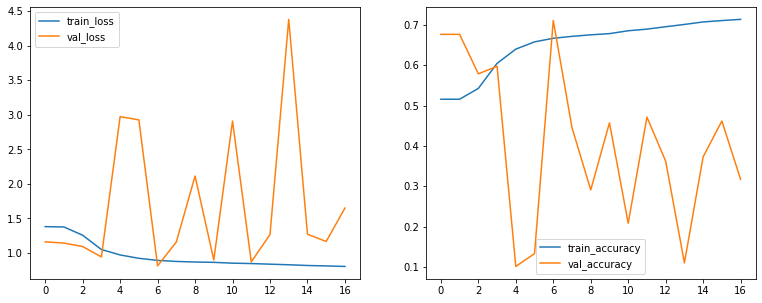

In [125]:
#predicted_classes = model.predict(X_test > 0.5).astype("int32")[:, 0]
#print(f'test recall score = {recall_score(y_test,predicted_classes)}')
fig, ax = plt.subplots(1,2,figsize=(13,5))
ax[0].plot(hist.history['loss'],label='train_loss')
ax[0].plot(hist.history['val_loss'],label='val_loss')
ax[0].legend()
ax[1].plot(hist.history['accuracy'],label='train_accuracy')
ax[1].plot(hist.history['val_accuracy'],label='val_accuracy')
ax[1].legend()

In [99]:
train_data

,fips_,year_,week_num_,PRECTOT_mean,PS_mean,QV2M_mean,T2M_mean,T2MDEW_mean,T2MWET_mean,T2M_MAX_mean,...,TS_mean,WS10M_mean,WS10M_MAX_mean,WS10M_MIN_mean,WS10M_RANGE_mean,WS50M_mean,WS50M_MAX_mean,WS50M_MIN_mean,WS50M_RANGE_mean,score_max
0,1001,2000,1,5.261429,100.702857,6.491429,9.878571,5.648571,5.674286,16.345714,...,9.397143,2.630000,3.722857,1.520000,2.201429,5.044286,6.934286,2.815714,4.120000,1.0
1,1001,2000,2,3.554286,101.100000,6.104286,9.662857,5.527143,5.552857,16.751429,...,9.431429,2.472857,3.585714,1.568571,2.018571,5.142857,7.162857,2.968571,4.192857,2.0
2,1001,2000,3,4.017143,100.348571,6.090000,8.270000,4.834286,4.890000,13.738571,...,8.194286,2.507143,3.574286,1.461429,2.110000,4.702857,6.682857,2.997143,3.685714,2.0
3,1001,2000,4,3.742857,100.755714,3.072857,0.737143,-3.367143,-3.265714,5.570000,...,0.817143,2.774286,3.908571,1.664286,2.248571,4.928571,6.727143,3.244286,3.480000,2.0
4,1001,2000,5,0.000000,101.012857,3.142857,2.501429,-2.685714,-2.627143,10.460000,...,2.021429,2.211429,3.161429,1.225714,1.934286,4.125714,5.971429,2.045714,3.927143,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2759898,56043,2016,48,0.211429,82.517143,2.265714,-3.541429,-9.130000,-9.007143,0.507143,...,-4.108571,4.227143,6.260000,2.197143,4.057143,6.231429,8.827143,3.687143,5.140000,0.0
2759899,56043,2016,49,0.624286,82.787143,1.841429,-8.072857,-12.847143,-12.498571,-3.115714,...,-8.557143,3.268571,5.190000,1.485714,3.704286,4.784286,7.161429,2.328571,4.831429,0.0
2759900,56043,2016,50,0.754286,82.602857,1.574286,-10.298571,-14.704286,-14.268571,-4.091429,...,-11.231429,3.212857,5.612857,1.051429,4.561429,4.600000,7.524286,1.565714,5.957143,0.0
2759901,56043,2016,51,0.775714,82.742857,2.201429,-5.717143,-9.964286,-9.821429,0.598571,...,-7.302857,4.641429,6.664286,2.394286,4.268571,6.905714,9.538571,4.108571,5.428571,0.0


In [284]:
scaled_train_data_ohe

,fips_,year_,week_num_,PRECTOT_mean,PS_mean,QV2M_mean,T2M_mean,T2MDEW_mean,T2MWET_mean,T2M_MAX_mean,...,WS50M_mean,WS50M_MAX_mean,WS50M_MIN_mean,WS50M_RANGE_mean,score_max_0,score_max_1,score_max_2,score_max_3,score_max_4,score_max_5
0,1001,2000,1,1.078902,0.591231,-0.067941,-0.230095,-0.112909,-0.112313,-0.219685,...,-0.129051,-0.194828,-0.105528,-0.155185,0.0,1.0,0.0,0.0,0.0,0.0
1,1001,2000,2,0.566467,0.689533,-0.123068,-0.242940,-0.120815,-0.120243,-0.195707,...,-0.089120,-0.125862,-0.015913,-0.118202,0.0,0.0,1.0,0.0,0.0,0.0
2,1001,2000,3,0.705403,0.503536,-0.125102,-0.325876,-0.165923,-0.163526,-0.373768,...,-0.267361,-0.270690,0.000838,-0.375635,0.0,0.0,1.0,0.0,0.0,0.0
3,1001,2000,4,0.623070,0.604314,-0.554719,-0.774413,-0.699870,-0.696082,-0.856534,...,-0.175926,-0.257328,0.145729,-0.480058,0.0,0.0,1.0,0.0,0.0,0.0
4,1001,2000,5,-0.500429,0.667963,-0.544752,-0.669360,-0.655506,-0.654384,-0.567533,...,-0.501157,-0.485345,-0.556951,-0.253082,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275984,12041,2013,27,4.312607,0.796676,1.561839,0.707298,1.049200,1.051679,0.526753,...,-0.330440,-0.628879,0.214405,-1.163162,1.0,0.0,0.0,0.0,0.0,0.0
275985,12041,2013,28,2.399657,0.756365,1.504475,0.765652,1.022600,1.024907,0.640057,...,-1.034144,-1.075000,-0.664992,-1.151559,1.0,0.0,0.0,0.0,0.0,0.0
275986,12041,2013,29,1.988851,0.825672,1.487795,0.713678,1.019252,1.021549,0.563311,...,-0.503472,-0.747414,0.067002,-1.235678,1.0,0.0,0.0,0.0,0.0,0.0
275987,12041,2013,30,2.430532,0.717115,1.593369,0.758506,1.058315,1.060728,0.594044,...,-0.587963,-0.752155,-0.114740,-1.086294,1.0,0.0,0.0,0.0,0.0,0.0


In [295]:
#Pipeline

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn import set_config; set_config(display='diagram')


class Window(): 
    
    def fit(self,data):
        self.data = data
        self.window = WindowGenerator(self.data,input_width=6,label_width=6,shift=1,label_columns=['score_max_0','score_max_1','score_max_2','score_max_3','score_max_4','score_max_5'])
        return self
 
    def transform(self,data):
        data_windowed = self.window.make_dataset()
        return data_windowed

def initialize_model():
    model = models.Sequential()
    model.add(layers.LSTM(32,return_sequences=True,activation='tanh'))
    model.add(layers.LSTM(32,return_sequences=True,activation='tanh'))
    model.add(layers.Dense(20,activation='relu'))
    model.add(layers.Dense(6,activation='softmax'))
    model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
    return model

scaling_pipe = Pipeline([('robust_scaler',RobustScaler())])
encoder = Pipeline([('ohe',OneHotEncoder())])
preprocessor = ColumnTransformer([('scaling',scaling_pipe,train_data.drop(columns=['fips_','year_','week_num_','score_max']).columns),('cat_encoder',encoder,['score_max'])],remainder='passthrough')

window_generator = Pipeline([('window',Window())])
windower = ColumnTransformer([('window',window_generator,[col for col in scaled_train_data_ohe.columns])])

keras_wrapper_model = KerasClassifier(build_fn=initialize_model,epochs=1,batch_size=32,callbacks=EarlyStopping(patience=10,restore_best_weights=True),verbose=1)

final_pipe = Pipeline([('preprocessing', preprocessor),('window_generator',windower),('KerasClassifier', keras_wrapper_model)])
final_pipe_trained = final_pipe.fit(train_data)
final_pipe

ValueError: Specifying the columns using strings is only supported for pandas DataFrames

In [292]:
ColumnTransformer([('window',window_generator,[col for col in scaled_train_data_ohe.columns])])

ColumnTransformer(transformers=[('window',
                                 Pipeline(steps=[('window',
                                                  <__main__.Window object at 0x164e22a60>)]),
                                 ['fips_', 'year_', 'week_num_', 'PRECTOT_mean',
                                  'PS_mean', 'QV2M_mean', 'T2M_mean',
                                  'T2MDEW_mean', 'T2MWET_mean', 'T2M_MAX_mean',
                                  'T2M_MIN_mean', 'T2M_RANGE_mean', 'TS_mean',
                                  'WS10M_mean', 'WS10M_MAX_mean',
                                  'WS10M_MIN_mean', 'WS10M_RANGE_mean',
                                  'WS50M_mean', 'WS50M_MAX_mean',
                                  'WS50M_MIN_mean', 'WS50M_RANGE_mean',
                                  'score_max_0', 'score_max_1', 'score_max_2',
                                  'score_max_3', 'score_max_4',
                                  'score_max_5'])])

In [214]:
class Window(): 
    
    def fit(self,data):
        self.data = data
        self.w = WindowGenerator(self.data,input_width=6,label_width=6,shift=1,label_columns=['score_max_0','score_max_1','score_max_2','score_max_3','score_max_4','score_max_5'])
        return self
 
    def transform(self,data):
        data_windowed = self.w.make_dataset()
        return data_windowed

In [283]:
s = Window()
s.fit(scaled_train_data_ohe)
sa = s.transform(scaled_train_data_ohe)
sa

<MapDataset shapes: ((None, 6, 27), (None, 6, 6)), types: (tf.float32, tf.float32)>

In [215]:
d = Window()
d.fit(scaled_train_data_ohe)
d.transform(scaled_train_data_ohe)

2021-09-02 18:36:02.238457: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<MapDataset shapes: ((None, 6, 27), (None, 6, 6)), types: (tf.float32, tf.float32)>

In [162]:
scaling_pipe = Pipeline([('robust_scaler',RobustScaler())])
preped_data = ColumnTransformer([('scaling',scaling_pipe,train_data.drop(columns=['fips_','year_','week_num_','score_max']).columns)],remainder='passthrough')

In [163]:
preped_data

ColumnTransformer(remainder='passthrough',
                  transformers=[('scaling',
                                 Pipeline(steps=[('robust_scaler',
                                                  RobustScaler())]),
                                 Index(['PRECTOT_mean', 'PS_mean', 'QV2M_mean', 'T2M_mean', 'T2MDEW_mean',
       'T2MWET_mean', 'T2M_MAX_mean', 'T2M_MIN_mean', 'T2M_RANGE_mean',
       'TS_mean', 'WS10M_mean', 'WS10M_MAX_mean', 'WS10M_MIN_mean',
       'WS10M_RANGE_mean', 'WS50M_mean', 'WS50M_MAX_mean', 'WS50M_MIN_mean',
       'WS50M_RANGE_mean'],
      dtype='object'))])

In [127]:
custom_scaler = CustomScaler(train_data)

In [128]:
custom_scaler.fit()
scaled = custom_scaler.transform()

In [129]:
scaled

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,fips_,year_,week_num_,score_max
0,1.078902,0.591231,-0.067941,-0.230095,-0.112909,-0.112313,-0.219685,-0.258804,0.360444,-0.255814,...,-0.230955,-0.388817,-0.129051,-0.194828,-0.105528,-0.155185,1001.0,2000.0,1.0,1.0
1,0.566467,0.689533,-0.123068,-0.242940,-0.120815,-0.120243,-0.195707,-0.303309,0.652126,-0.253813,...,-0.189843,-0.471080,-0.089120,-0.125862,-0.015913,-0.118202,1001.0,2000.0,2.0,2.0
2,0.705403,0.503536,-0.125102,-0.325876,-0.165923,-0.163526,-0.373768,-0.311538,-0.094270,-0.325998,...,-0.280532,-0.429949,-0.267361,-0.270690,0.000838,-0.375635,1001.0,2000.0,3.0,2.0
3,0.623070,0.604314,-0.554719,-0.774413,-0.699870,-0.696082,-0.856534,-0.690320,-0.625139,-0.756439,...,-0.108827,-0.367609,-0.175926,-0.257328,0.145729,-0.480058,1001.0,2000.0,4.0,2.0
4,-0.500429,0.667963,-0.544752,-0.669360,-0.655506,-0.654384,-0.567533,-0.722704,0.775231,-0.686172,...,-0.480048,-0.508997,-0.501157,-0.485345,-0.556951,-0.253082,1001.0,2000.0,5.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2756791,-0.436964,-3.910184,-0.669650,-1.029177,-1.075056,-1.070989,-1.155751,-0.924792,-0.955268,-1.043844,...,0.342201,0.446015,0.351852,0.376293,0.405360,0.362582,56037.0,2008.0,23.0,2.0
2756792,-0.313036,-3.843352,-0.730065,-1.298996,-1.317057,-1.298974,-1.369863,-1.257388,-0.503142,-1.303409,...,-0.259976,0.287275,-0.234375,-0.126293,-0.391122,0.205946,56037.0,2008.0,24.0,2.0
2756793,-0.274014,-3.888967,-0.768104,-1.431524,-1.437965,-1.414552,-1.427528,-1.448416,0.041774,-1.459448,...,-0.627570,0.672879,-0.309028,-0.016810,-0.838358,0.777375,56037.0,2008.0,25.0,2.0
2756794,-0.267581,-3.854314,-0.678804,-1.158727,-1.129371,-1.124160,-1.150347,-1.188374,0.169316,-1.230224,...,0.509069,0.541131,0.625000,0.590948,0.652429,0.509065,56037.0,2008.0,26.0,2.0


In [57]:
scaled_train_data.head()

,fips_,year_,week_num_,PRECTOT_mean,PS_mean,QV2M_mean,T2M_mean,T2MDEW_mean,T2MWET_mean,T2M_MAX_mean,...,TS_mean,WS10M_mean,WS10M_MAX_mean,WS10M_MIN_mean,WS10M_RANGE_mean,WS50M_mean,WS50M_MAX_mean,WS50M_MIN_mean,WS50M_RANGE_mean,score_max
0,1001,2000,1,1.078902,0.591231,-0.067941,-0.230095,-0.112909,-0.112313,-0.219685,...,-0.255814,-0.339502,-0.381897,-0.230955,-0.388817,-0.129051,-0.194828,-0.105528,-0.155185,1.0
1,1001,2000,2,0.566467,0.689533,-0.123068,-0.242940,-0.120815,-0.120243,-0.195707,...,-0.253813,-0.409700,-0.423276,-0.189843,-0.471080,-0.089120,-0.125862,-0.015913,-0.118202,2.0
2,1001,2000,3,0.705403,0.503536,-0.125102,-0.325876,-0.165923,-0.163526,-0.373768,...,-0.325998,-0.394384,-0.426724,-0.280532,-0.429949,-0.267361,-0.270690,0.000838,-0.375635,2.0
3,1001,2000,4,0.623070,0.604314,-0.554719,-0.774413,-0.699870,-0.696082,-0.856534,...,-0.756439,-0.275048,-0.325862,-0.108827,-0.367609,-0.175926,-0.257328,0.145729,-0.480058,2.0
4,1001,2000,5,-0.500429,0.667963,-0.544752,-0.669360,-0.655506,-0.654384,-0.567533,...,-0.686172,-0.526484,-0.551293,-0.480048,-0.508997,-0.501157,-0.485345,-0.556951,-0.253082,1.0


In [61]:
pd.DataFrame(s)

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,-1.046286,-1.0,-1.000000,1.078902,0.591231,-0.067941,-0.230095,-0.112909,-0.112313,-0.219685,...,-0.255814,-0.339502,-0.381897,-0.230955,-0.388817,-0.129051,-0.194828,-0.105528,-0.155185,1.0
1,-1.046286,-1.0,-0.961538,0.566467,0.689533,-0.123068,-0.242940,-0.120815,-0.120243,-0.195707,...,-0.253813,-0.409700,-0.423276,-0.189843,-0.471080,-0.089120,-0.125862,-0.015913,-0.118202,2.0
2,-1.046286,-1.0,-0.923077,0.705403,0.503536,-0.125102,-0.325876,-0.165923,-0.163526,-0.373768,...,-0.325998,-0.394384,-0.426724,-0.280532,-0.429949,-0.267361,-0.270690,0.000838,-0.375635,2.0
3,-1.046286,-1.0,-0.884615,0.623070,0.604314,-0.554719,-0.774413,-0.699870,-0.696082,-0.856534,...,-0.756439,-0.275048,-0.325862,-0.108827,-0.367609,-0.175926,-0.257328,0.145729,-0.480058,2.0
4,-1.046286,-1.0,-0.846154,-0.500429,0.667963,-0.544752,-0.669360,-0.655506,-0.654384,-0.567533,...,-0.686172,-0.526484,-0.551293,-0.480048,-0.508997,-0.501157,-0.485345,-0.556951,-0.253082,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2756791,0.995104,1.0,0.807692,-0.436964,-3.910184,-0.669650,-1.029177,-1.075056,-1.070989,-1.155751,...,-1.043844,0.373963,0.383621,0.342201,0.446015,0.351852,0.376293,0.405360,0.362582,0.0
2756792,0.995104,1.0,0.846154,-0.313036,-3.843352,-0.730065,-1.298996,-1.317057,-1.298974,-1.369863,...,-1.303409,-0.054244,0.060776,-0.259976,0.287275,-0.234375,-0.126293,-0.391122,0.205946,0.0
2756793,0.995104,1.0,0.884615,-0.274014,-3.888967,-0.768104,-1.431524,-1.437965,-1.414552,-1.427528,...,-1.459448,-0.079132,0.188362,-0.627570,0.672879,-0.309028,-0.016810,-0.838358,0.777375,0.0
2756794,0.995104,1.0,0.923077,-0.267581,-3.854314,-0.678804,-1.158727,-1.129371,-1.124160,-1.150347,...,-1.230224,0.559030,0.505603,0.509069,0.541131,0.625000,0.590948,0.652429,0.509065,0.0


### Manual coding method

In [ ]:
def split_subsample_sequence(df, length):
    df_sample = df.sample(length)
    X_sample = df_sample.iloc[:-1].copy()
    y_sample = float(df_sample[['score_max']].iloc[-1])
    
    return X_sample, y_sample

def get_X_y(df, n_sequences, length):
    X = [split_subsample_sequence(df, length)[0] for n in range(n_sequences)]
    y = [split_subsample_sequence(df, length)[1] for n in range(n_sequences)]
    
    
    return np.array(X),np.array(y)

In [ ]:
d = data[:1000]

In [ ]:
X,y = get_X_y(d, 2000, 21)

In [ ]:
def split_subsample_sequence(df, length):
    df_sample = df.sample(length,random_state=1)
    X_sample = df_sample.iloc[:-1].copy()
    y_sample = float(df_sample[['score_max']].iloc[-1])
    
    return X_sample, y_sample

def get_X_y(df, n_sequences,length):
    X = []
    y = []
    for n in range(n_sequences):
        sequence = split_subsample_sequence(df, length)
        X.append(sequence[0])
        y.append(sequence[1])
    
    return np.array(X),np.array(y)

def get_X_y_by_geolocation(df, n_sequences, length):
    X = []
    y = []
    for fip in sorted(set(df['fips_'])):
        fip_df = df[df['fips_'] == fip]
        sequences = get_X_y(fip_df,n_sequences,length)
        X.append(sequences[0])
        y.append(sequences[1])
        

    return np.array(X),np.array(y)